In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install keras-tuner

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Attention,Layer, Input
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [ ]:
!unzip /content/drive/MyDrive/facial_expression_recognition/datasetface.zip -d extracted_data/

In [12]:
image = cv2.imread('/content/extracted_data/MMAFEDB/test/angry/10Exp0angry_actor_150.jpg')

In [13]:
print(image.shape)

(48, 48, 3)


In [ ]:
train_directory = '/content/extracted_data/MMAFEDB/train'
test_directory = '/content/extracted_data/MMAFEDB/test'
valid_directory = '/content/extracted_data/MMAFEDB/valid'

def count_images_in_directory(directory):
    categories = os.listdir(directory)
    total_images = 0
    counts = {}

    for category in categories:
        count = len(os.listdir(os.path.join(directory, category)))
        counts[category] = count
        total_images += count

    return total_images, counts

train_total, train_counts = count_images_in_directory(train_directory)
test_total, test_counts = count_images_in_directory(test_directory)
valid_total, valid_counts = count_images_in_directory(valid_directory)

print(f'Total gambar di folder train: {train_total}')
for category, count in train_counts.items():
    print(f'Jumlah gambar di kelas {category}: {count}')

print(f'\nTotal gambar di folder valid: {valid_total}')
for category, count in valid_counts.items():
    print(f'Jumlah gambar di kelas {category}: {count}')

print(f'\nTotal gambar di folder test: {test_total}')
for category, count in test_counts.items():
    print(f'Jumlah gambar di kelas {category}: {count}')

total_all = train_total + valid_total + test_total
print(f'\nTotal semua gambar: {total_all}')

def plot_image_counts(train_counts, valid_counts, test_counts):
    categories = list(train_counts.keys())
    train_values = list(train_counts.values())
    valid_values = list(valid_counts.values())
    test_values = list(test_counts.values())

    x = range(len(categories))

    plt.figure(figsize=(12, 6))


    plt.bar(x, train_values, width=0.2, label='Train', align='center')
    plt.bar([p + 0.2 for p in x], valid_values, width=0.2, label='Validation', align='center')
    plt.bar([p + 0.4 for p in x], test_values, width=0.2, label='Test', align='center')

    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Jumlah Gambar per Kelas')
    plt.xticks([p + 0.2 for p in x], categories)
    plt.legend()
    plt.grid(axis='y')

    plt.show()


plot_image_counts(train_counts, valid_counts, test_counts)


#### Data Preprocessing

In [63]:
image_size = (48, 48)
batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    # featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

)


train_generator = train_datagen.flow_from_directory(
    '/content/extracted_data/MMAFEDB/train',  # Path ke folder train
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/extracted_data/MMAFEDB/valid',  # Path ke folder valid
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    '/content/extracted_data/MMAFEDB/test',  # Path ke folder test
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

labels = train_generator.class_indices
print(labels)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


#### Tampilkan sampel gambar augmented


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


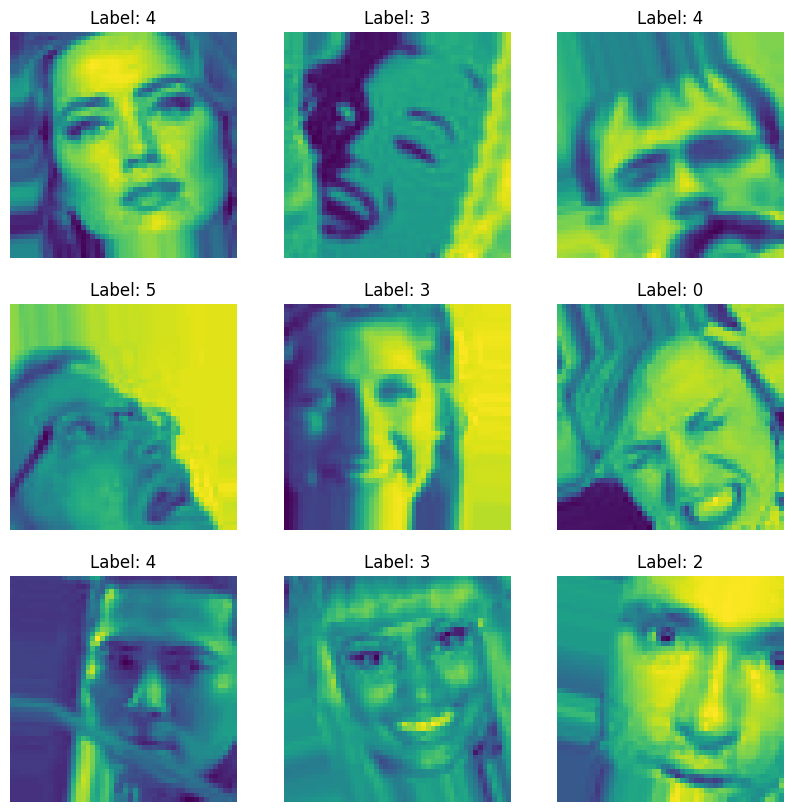

In [64]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'Label: {y_batch[i].argmax()}')
    plt.axis('off')
plt.show()


### **Building the CNN Model**

In [76]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation='softmax'))

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

### **Setting Callbacks**

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Daftar callback
)


Epoch 1/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 396s 135ms/step - accuracy: 0.3382 - loss: 1.6647 - val_accuracy: 0.3889 - val_loss: 1.5441 - learning_rate: 0.0010
Epoch 2/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 384s 132ms/step - accuracy: 0.4465 - loss: 1.5042 - val_accuracy: 0.4537 - val_loss: 1.5024 - learning_rate: 0.0010
Epoch 3/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 381s 131ms/step - accuracy: 0.5106 - loss: 1.3761 - val_accuracy: 0.4466 - val_loss: 1.5563 - learning_rate: 0.0010
Epoch 4/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 383s 132ms/step - accuracy: 0.5347 - loss: 1.3194 - val_accuracy: 0.4883 - val_loss: 1.4427 - learning_rate: 0.0010
Epoch 5/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 441s 131ms/step - accuracy: 0.5490 - loss: 1.2849 - val_accuracy: 0.4812 - val_loss: 1.4476 - learning_rate: 0.0010
Epoch 6/50
1017/2906 ━━━━━━━━━━━━━━━━━━━━ 3:54 124ms/step - accuracy: 0.5591 - loss: 1.2604

KeyboardInterrupt: 

In [ ]:
print(f'Learning Rate Terakhir: {model.optimizer.lr.numpy()}')


NameError: name 'history' is not defined

### **Training Model**

### **Evaluating the Model**

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Panggil fungsi ini setelah training selesai
plot_training_history(history)


#### Confusion Matrix dan Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prediksi pada test data
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))


### **Final Model Deployment Check**

In [ ]:
import time
start = time.time()
pred = best_model.predict(test_generator)
end = time.time()
print(f'Inference time: {end - start} seconds')
